<a href="https://colab.research.google.com/github/yushunli2013/NBA-Shot-Prediction/blob/master/NBA_Shot_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBA Shot Predictor
![alt text](http://geog.ucsb.edu/img/news/2014/ff_mccluskyexcerptgallery_f.jpg)

Inspired by a [TEDtalk on NBA analytics](https://www.ted.com/talks/rajiv_maheswaran_the_math_behind_basketball_s_wildest_moves?language=en), I sought to explore the power of machine learning to predict the result of a shot in the NBA. 

Using a [dataset from Kaggle](https://www.kaggle.com/wh0801/NBA-16-17-regular-season-shot-log) that recorded every single shot from the 2016-2017 season, I tested various machine learning prediction models and evaluated results.

# Ingest

In [0]:
#Importing required packages.
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.image as mpimg 
%matplotlib inline
from sklearn import preprocessing

In [3]:
#Loading dataset
nba_df = pd.read_csv("https://raw.githubusercontent.com/yushunli2013/NBA-Shot-Prediction/master/shot%20log_all%20teams_v4.csv")
nba_df.head()

,self previous shot,opponent previous shot,X,Y,shot type,Team,Opponent,home game,points,time_secs,date,Position,Player,time from last shot,quarter,current shot outcome
0,0,3,97,405,Pullup Jump Shot,ATL,WAS,1,2,69,10/27/16,3,Kent Bazemore,-1,1,0
1,2,3,52,250,Tip Dunk Shot,ATL,WAS,1,2,71,10/27/16,5,Dwight Howard,2,1,1
2,3,1,239,223,Jump Shot,ATL,WAS,1,2,101,10/27/16,2,Kyle Korver,30,1,1
3,3,3,102,385,Pullup Jump Shot,ATL,WAS,1,2,136,10/27/16,1,Dennis Schroder,35,1,1
4,3,1,128,265,Turnaround Jump Shot,ATL,WAS,1,2,160,10/27/16,4,Paul Millsap,24,1,0


In [4]:
#Drop statistically irrelevant/identification columns
nba_df.drop(['date'], inplace=True, axis=1)
nba_df.head()

,self previous shot,opponent previous shot,X,Y,shot type,Team,Opponent,home game,points,time_secs,Position,Player,time from last shot,quarter,current shot outcome
0,0,3,97,405,Pullup Jump Shot,ATL,WAS,1,2,69,3,Kent Bazemore,-1,1,0
1,2,3,52,250,Tip Dunk Shot,ATL,WAS,1,2,71,5,Dwight Howard,2,1,1
2,3,1,239,223,Jump Shot,ATL,WAS,1,2,101,2,Kyle Korver,30,1,1
3,3,3,102,385,Pullup Jump Shot,ATL,WAS,1,2,136,1,Dennis Schroder,35,1,1
4,3,1,128,265,Turnaround Jump Shot,ATL,WAS,1,2,160,4,Paul Millsap,24,1,0


# EDA

## Correlation Heatmap

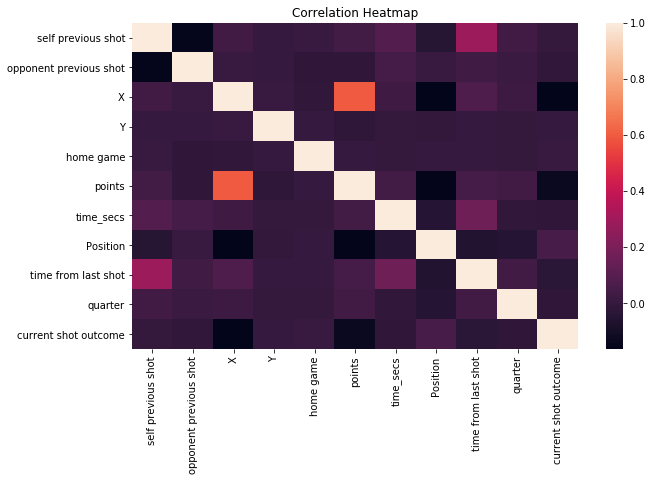

In [5]:
#define correlation of statistics
corr = nba_df.corr()
#create heatmap
plt.subplots(figsize=(10,6))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)



*   X coordinate has a negative correlation to current outcome, which makes sense because the farther away you are the less likely you will make the basket



## Shot Map Per Team

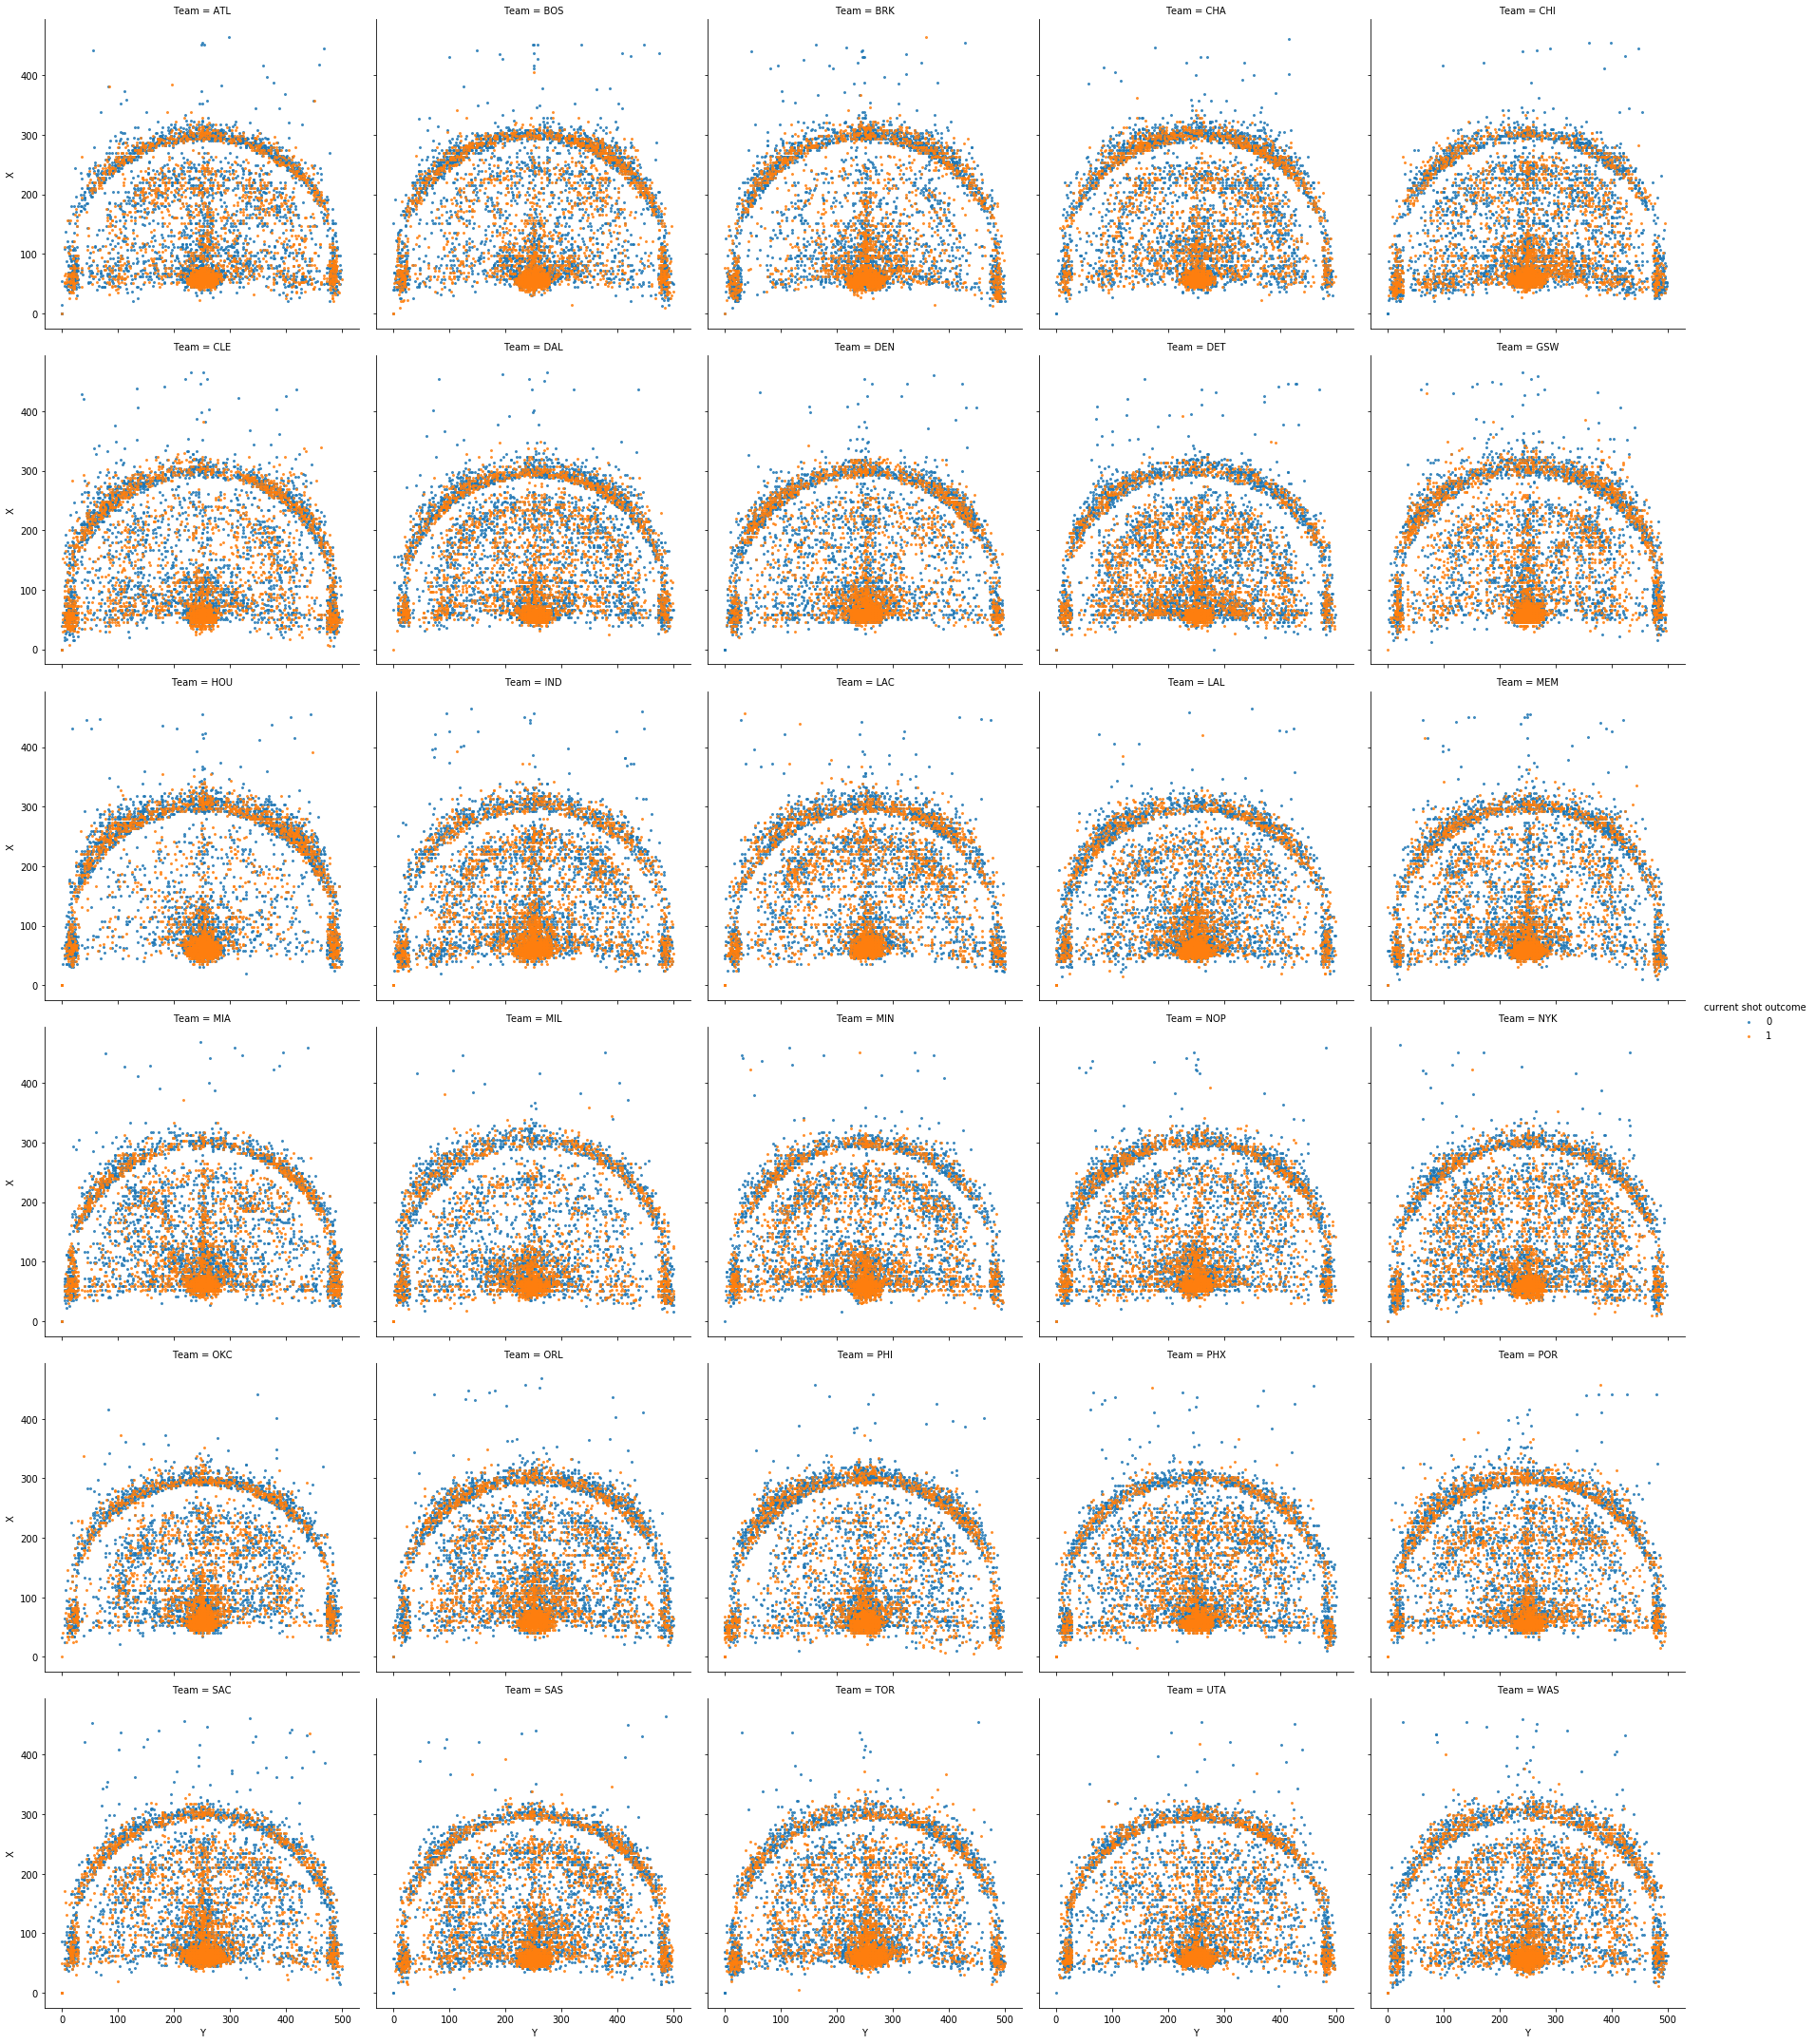

In [6]:
#In order to better understand the factors around made shots, we need to better visualize the Data
nba_shot_halfcourt_df = nba_df.query('X<470')
#Filter shot data within the halfcourt, anything over 470 is an outlier
sns.lmplot('Y', # Vertical coordinate of shot
           'X', # Horizontal coordinate of shot
           col="Team", col_wrap= 5, #Display plot by team
           data=nba_shot_halfcourt_df, # Data source
           fit_reg=False, # Don't fix a regression line
           hue='current shot outcome', legend=True,
           scatter_kws={"s": 4}) # S marker size



*   Most teams have similar shot charts
*   Teams like the Houston Rockets have an emphasis on taking less mid-range shots



# Data Cleaning

## Encoding Categorical Values

In [7]:
#Encode Player Data
data = nba_df['Player']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
player_encoded = label_encoder.fit_transform(values)
print(player_encoded)

['Kent Bazemore' 'Dwight Howard' 'Kyle Korver' ... 'Daniel Ochefu'
 'Chris McCullough' 'Trey Burke']
[264 132 277 ...  90  75 455]


In [8]:
#Encode Team Data
teams = nba_df['Team']
team_names = array(teams)
print(team_names)
# integer encode
team_encoded = label_encoder.fit_transform(team_names)
print(team_encoded)

['ATL' 'ATL' 'ATL' ... 'WAS' 'WAS' 'WAS']
[ 0  0  0 ... 29 29 29]


In [9]:
#Encode Opponent Data
opp_teams = nba_df['Opponent']
opp_names = array(opp_teams)
print(opp_names)
# integer encode
opp_encoded = label_encoder.fit_transform(opp_names)
print(opp_encoded)

['WAS' 'WAS' 'WAS' ... 'MIA' 'MIA' 'MIA']
[29 29 29 ... 15 15 15]


In [10]:
#Encode shot type
shots = nba_df['shot type']
shot_type = array(shots)
print(shot_type)
# integer encode
shot_encoded = label_encoder.fit_transform(shot_type)
print(shot_encoded)

['Pullup Jump Shot' 'Tip Dunk Shot' 'Jump Shot' ... 'Jump Shot'
 'Jump Shot' 'Jump Shot']
[35 52 32 ... 32 32 32]


In [11]:
#Convert array into dataframe
player_id = pd.DataFrame({'player_id':player_encoded})
team_id = pd.DataFrame({'team_id':team_encoded})
opp_id = pd.DataFrame({'opp_team_id':opp_encoded})
shot_id = pd.DataFrame({'shot_type_id':shot_encoded})
#Insert ID Dataframes into NBA dataframe
consolidated_df = pd.concat([nba_df, player_id, shot_id, team_id, opp_id], axis=1)
consolidated_df.head()

,self previous shot,opponent previous shot,X,Y,shot type,Team,Opponent,home game,points,time_secs,Position,Player,time from last shot,quarter,current shot outcome,player_id,shot_type_id,team_id,opp_team_id
0,0,3,97,405,Pullup Jump Shot,ATL,WAS,1,2,69,3,Kent Bazemore,-1,1,0,264,35,0,29
1,2,3,52,250,Tip Dunk Shot,ATL,WAS,1,2,71,5,Dwight Howard,2,1,1,132,52,0,29
2,3,1,239,223,Jump Shot,ATL,WAS,1,2,101,2,Kyle Korver,30,1,1,277,32,0,29
3,3,3,102,385,Pullup Jump Shot,ATL,WAS,1,2,136,1,Dennis Schroder,35,1,1,112,35,0,29
4,3,1,128,265,Turnaround Jump Shot,ATL,WAS,1,2,160,4,Paul Millsap,24,1,0,371,60,0,29


## Scale Data

In [12]:
#Drop categorical variables
consolidated_df.drop(['Team', 'Opponent', 'shot type', 'Player'], inplace=True, axis=1)
consolidated_df.head()

,self previous shot,opponent previous shot,X,Y,home game,points,time_secs,Position,time from last shot,quarter,current shot outcome,player_id,shot_type_id,team_id,opp_team_id
0,0,3,97,405,1,2,69,3,-1,1,0,264,35,0,29
1,2,3,52,250,1,2,71,5,2,1,1,132,52,0,29
2,3,1,239,223,1,2,101,2,30,1,1,277,32,0,29
3,3,3,102,385,1,2,136,1,35,1,1,112,35,0,29
4,3,1,128,265,1,2,160,4,24,1,0,371,60,0,29


In [0]:
#Split X and Y to predict if the shot was made or missed
X = consolidated_df.drop('current shot outcome', axis = 1)
y = consolidated_df['current shot outcome']

In [18]:
#Scale the X(Input) data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,1.000000,0.206823,0.810,1.0,0.0,0.092050,0.50,0.000000,0.0,0.545455,0.583333,0.0,1.0
1,0.666667,1.000000,0.110874,0.500,1.0,0.0,0.094840,1.00,0.011719,0.0,0.272727,0.866667,0.0,1.0
2,1.000000,0.333333,0.509595,0.446,1.0,0.0,0.136681,0.25,0.121094,0.0,0.572314,0.533333,0.0,1.0
3,1.000000,1.000000,0.217484,0.770,1.0,0.0,0.185495,0.00,0.140625,0.0,0.231405,0.583333,0.0,1.0
4,1.000000,0.333333,0.272921,0.530,1.0,0.0,0.218968,0.75,0.097656,0.0,0.766529,1.000000,0.0,1.0


# Predictive Modeling

In [0]:
#Split Data into Test and Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Random Forest Modeling

In [63]:
#Fit Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
#Predict through Random Forest Classifier
pred_rfc = rfc.predict(X_test)
# Check results
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.64      0.79      0.71     28525
           1       0.65      0.47      0.55     23993

    accuracy                           0.64     52518
   macro avg       0.65      0.63      0.63     52518
weighted avg       0.65      0.64      0.63     52518



## Logistic Regression

In [0]:
#Create Logistic Regression Parameters
logreg = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [24]:
#Find Best Parameters Grid
logreg_grid = GridSearchCV(logreg,
                        hyperparameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

logreg_grid.fit(X_train,
         y_train)

print(logreg_grid.best_score_)
print(logreg_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5855897025781637
{'C': 1291.5496650148827, 'penalty': 'l1'}


In [25]:
#Predict ShotOutCome
pred_log = logreg_grid.predict(X_test)
# Check results
print(classification_report(y_test, pred_log))

              precision    recall  f1-score   support

           0       0.60      0.69      0.64     28525
           1       0.55      0.46      0.50     23993

    accuracy                           0.58     52518
   macro avg       0.58      0.57      0.57     52518
weighted avg       0.58      0.58      0.58     52518



## Gaussian Naive Bayes

In [58]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
pred_gnb = gaussian.predict(X_test)
# Check results
print(classification_report(y_test, pred_gnb))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60     28525
           1       0.54      0.60      0.57     23993

    accuracy                           0.59     52518
   macro avg       0.59      0.59      0.59     52518
weighted avg       0.59      0.59      0.59     52518



## XGBoost

In [46]:
#Setup Data Parametes in xGB
import xgboost as xgb
xgb.DMatrix(X, label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [49]:
from sklearn.metrics import mean_absolute_error
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 0.50


In [0]:
#Define Parameters
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}
params['eval_metric'] = "mae"
num_boost_round = 999

In [53]:
#Identify Optimal Number of Rounds via NumBoostRound
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[22:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.481528
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.468229
[2]	Test-mae:0.459001
[3]	Test-mae:0.452081
[4]	Test-mae:0.447242
[5]	Test-mae:0.443458
[6]	Test-mae:0.440952
[7]	Test-mae:0.439478
[8]	Test-mae:0.437504
[9]	Test-mae:0.436545
[10]	Test-mae:0.435783
[11]	Test-mae:0.435008
[12]	Test-mae:0.434507
[13]	Test-mae:0.434083
[14]	Test-mae:0.433616
[15]	Test-mae:0.43342
[16]	Test-mae:0.433092
[17]	Test-mae:0.432981
[18]	Test-mae:0.432688
[19]	Test-mae:0.43248
[20]	Test-mae:0.432488
[21]	Test-mae:0.43244
[22]	Test-mae:0.432078
[23]	Test-mae:0.432156
[24]	Test-mae:0.431565
[25]	Test-mae:0.431272
[26]	Test-mae:0.431212
[27]	Test-mae:0.431176
[28]	Test-mae:0.431145
[29]	Test-mae:0.43098
[30]	Test-mae:0.430742
[31]	Test-mae:0.430761
[32]	Test-mae:0.430699
[33]	Test-mae:0.430615
[34]	Test-mae:0.430513
[35]	Test-mae:0.430616
[36

In [54]:
#Setup CrossValidation
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

[22:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.481077,0.000123,0.481355,0.000347
1,0.467574,0.000209,0.468071,0.000541
2,0.457887,0.000382,0.458654,0.000534
3,0.450865,0.000263,0.451993,0.000724
4,0.445370,0.000463,0.446752,0.000634
5,0.441644,0.000538,0.443316,0.000754
6,0.438928,0.000438,0.440910,0.000862
7,0.436571,0.000434,0.438909,0.000908
8,0.434972,0.000627,0.437639,0.000809
9,0.433582,0.000487,0.436563,0.000738


### Hyperparameter Tuning

In [0]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [57]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[22:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.4263852 for 76 rounds
CV with max_depth=9, min_child_weight=6
[22:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.4269414 for 66 rounds
CV with max_depth=9, min_child_weight=7
[22:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in 

In [0]:
#Set Best Parameter based on results
params['max_depth'] = 9
params['min_child_weight'] = 5

In [0]:
#Set Parameters via Subsampling
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [70]:
#Tune the Model
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
[22:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	MAE 0.4263852 for 76 rounds
CV with subsample=1.0, colsample=0.9
[22:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:41:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 0.427146 for 54 rounds
CV with subsample=1.0, colsample=0.8
[22:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:42:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor o

In [0]:
params['subsample'] = 1
params['colsample_bytree'] = 1

In [75]:
#Run Model with optimized parameters
params
{'colsample_bytree': 1.0,
 'eta': 0.01,
 'eval_metric': 'mae',
 'max_depth': 9,
 'min_child_weight': 5,
 'objective': 'reg:linear',
 'subsample':1}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[23:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:0.47961
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:0.465349
[2]	Test-mae:0.454934
[3]	Test-mae:0.44774
[4]	Test-mae:0.44248
[5]	Test-mae:0.439016
[6]	Test-mae:0.436603
[7]	Test-mae:0.434672
[8]	Test-mae:0.432916
[9]	Test-mae:0.431777
[10]	Test-mae:0.431184
[11]	Test-mae:0.430666
[12]	Test-mae:0.430481
[13]	Test-mae:0.42997
[14]	Test-mae:0.429632
[15]	Test-mae:0.429424
[16]	Test-mae:0.429189
[17]	Test-mae:0.429079
[18]	Test-mae:0.428842
[19]	Test-mae:0.42834
[20]	Test-mae:0.428405
[21]	Test-mae:0.428268
[22]	Test-mae:0.428154
[23]	Test-mae:0.42805
[24]	Test-mae:0.427899
[25]	Test-mae:0.427754
[26]	Test-mae:0.427636
[27]	Test-mae:0.427633
[28]	Test-mae:0.427645
[29]	Test-mae:0.427538
[30]	Test-mae:0.427565
[31]	Test-mae:0.427615
[32]	Test-mae:0.427252
[33]	Test-mae:0.427138
[34]	Test-mae:0.427191
[35]	Test-mae:0.42718
[36]	T

# Conclusion

Despite trying different models and different levels of hyperparameter tuning, most results averaged around 66-67% accuracy. This is not incredibly high, but given the data attributes, it is a decent starting point. 

There are many additional datafields that would improve the model like:


*   Time on the shot clock
*   Who is the closest defender
*   Distance and angle of closest defender
*   Similar datapoints for secondary defenders
*   Passes completed before the pass

**Application**

I believe with the ceiling of accuracy for such a model would be no higher than 85% and that is largely due to the randomness of NBA basketball. However, a model with 75% or higher accuracy be very useful simulations that can be conducted by teams or betting companies looking to optimize strategy basket-wise or financially, respectively. 

